In [1]:
import dill
dill.load_session('gtsrb.db')

Using TensorFlow backend.
/home/sakshi/dlProject/dlproject/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sakshi/dlProject/dlproject/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sakshi/dlProject/dlproject/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sakshi/dlProject/dlp

In [2]:
def max_diff(img1,img2):
    img = img1 - img2
    return np.amax(img)

def pred(image):
    global querycount
    querycount = querycount + 1
    data = []
    data.append(image)
    X_test = np.array(data)
    X_test = X_test.astype('float32')/255 
    pred = model.predict_classes(X_test)
    return pred[0]    

In [3]:
def boundary_estimation(source, target, dmin):
    Ii = ((source + target)/2.0)
    k = pred(Ii)
    delta = max_diff(source, Ii)
    Ia2 = source
    Ib2 = target
    p = Ib2
    while (delta > dmin):
        if (pred(Ib2) != k):
            Ia2 = Ii
        else:
            Ib2 = Ii
        Ii = ((Ia2+Ib2)/2.0)
        k = pred(Ii)
        delta = max_diff(Ia2,Ii)  
    return Ii

In [4]:
def go_out(iout,alpha,target,pred_target):
    i_diff = target - iout
    inew = iout
    while (pred(inew)!=pred_target):
        inew = inew + 0.3*(i_diff)  
    return inew

In [5]:
# source_image_path = 'gtsrb_dataset/kushbhinaamdede/0.png';
# target_image_path = 'gtsrb_dataset/kushbhinaamdede/4.png';
# img = (np.asarray(Image.open(source_image_path)))
# img1 = preprocess(img)
# source_image = np.array(img1)
# img = (np.asarray(Image.open(target_image_path)))
# img2 = preprocess(img)
# target_image = np.array(img2)

In [6]:
# Image.fromarray(source_image.astype('uint8')).show()

In [7]:
# Image.fromarray(target_image.astype('uint8')).show()

In [8]:
# print (pred(source_image))
# print (pred(target_image))

In [13]:
# ii = go_out(source_image,i,0.01,target_image)

In [14]:
# pred(ii)

In [15]:
# Image.fromarray(i.astype('uint8')).show()

In [17]:
# Image.fromarray(ii.astype('uint8')).show()

In [9]:
def array_diff(d1):
    sumd1 = 0.0
    for i in range(0,3):
        for j in range(0,30):
            for k in range(0,30):
                d1[j][k][i] = d1[j][k][i]*d1[j][k][i]
                sumd1 = sumd1 + d1[j][k][i]
    return (sumd1)

def gradient_estimation(source, target, adversarial, n, theta,pred_target):
    Ia = source
    Ib = target
    Ii = adversarial
    Io = np.zeros((2700))
    X = np.random.randint(0,2700, size=n)
    for i in X:
        Io[i] = 255
    Io = Io.reshape((30,30,3))
#     print(Io*theta)
    Ii2 = Ii + theta*Io
    Ii2_new = boundary_estimation(Ia, Ii2, 1.0)
    Ii2_new = go_out(Ii2_new,0.01,target,pred_target)
    diff2 = Ii2_new - Ia
    diff1 = Ii - Ia
    d2 = array_diff(diff2)
    d1 = array_diff(diff1)
    if (d2 > d1):
        return (-1, Ii2_new)
    elif (d1 > d2):
        return (1, Ii2_new)
    else:
        return (0,Ii2_new)
    

In [10]:
def efficient_update(source, target, adversarial, I2, g, j,pred_target):
    Ia = source
    Ib = target
    Ii = adversarial
    Ii2 = I2
    delta = g*(Ii2 - Ii)
    l = j
    Inew = Ii + l*delta
    
    diff1 = Inew - Ia
    diff2 = Ii - Ia
    d1 = array_diff(diff1)
    d2 = array_diff(diff2)
    ii = 0
#     pred_target = pred(target)
    it = 0
    while(d1 > d2):
        l = (l/2.0)
        Inew = Ii + l*delta
        if(pred(Inew)!=pred_target):
            Inew = go_out(Inew,0.01,target,pred_target)
        it = it + 1
        d1 = array_diff(Inew-Ia)
        if(it>100):
            break
    if (d1 > d2):
        print(ii)
        ii = ii + 1
        Inew = Ii
    return Inew

In [57]:
def iteration(itr, source, target, n, theta, j, dmin):
    targett = target
    sourcee = source
    pred_source = pred(source)
    pred_target = pred(target)
    q = []
    csi = []
    for i in range(itr):
        print (i)
        adversarial_image = boundary_estimation(sourcee, targett, dmin)
        adversarial_image = go_out(adversarial_image,0.01,target, pred_target)
        (g, Iii2) = gradient_estimation(sourcee, targett, targett, n, theta, pred_target)
        targett = efficient_update(sourcee, targett, adversarial_image, Iii2, g, j, pred_target)
        #         print ("i" ,i)
        
        if (pred(targett) != pred_source):
            j = j
        fin = targett
        if(pred(targett)!=pred_target):
            fin = go_out(targett,0.01,target, pred_target)
        if(array_diff(fin-sourcee)<array_diff(adversarial_image-sourcee)):
            targett = fin
            #print("uopp")
        q.append(querycount)
#         print(querycount)
        Image.fromarray(fin.astype('uint8')).save('19.png')
        perturb = cv2.imread("19.png")
        s = measure.compare_ssim(original,perturb,multichannel=True)
        csi.append(s)
#         print(s)
    return (csi, q)

In [58]:
global querycount 
querycount = 0
print(querycount)

0


In [70]:
q = []
csi = []
for i in range (29,33):
        q1 = []
        csi1 = []
        global querycount 
        querycount = 0
        target_image_path = 'gtsrb_dataset/kushbhinaamdede/{0}.png'.format(i)
        img = (np.asarray(Image.open(target_image_path)))
        img1 = preprocess(img)
        target_image1 = np.array(img1)
        (q1,csi1) = iteration(75,source_image,target_image1,5,0.196,1.0,1.0)
        q.append(q1)
        csi.append(csi1)

0


/home/sakshi/dlProject/dlproject/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  
/home/sakshi/dlProject/dlproject/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


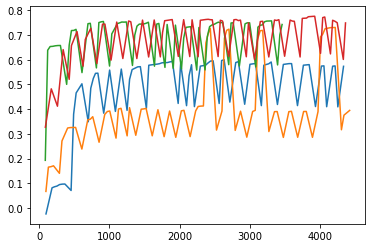

In [72]:
plt.plot(csi[0], q[0], csi[1], q[1], csi[2], q[2], csi[3], q[3])

In [38]:
import cv2
from skimage import measure
import matplotlib.pyplot as plt

In [153]:
original = cv2.imread("oo.png")
for i in range(43):
    Image.fromarray(arr[i].astype('uint8')).save('o0.png')
    perturb = cv2.imread('o0.png')
    print(i,measure.compare_ssim(original,perturb,multichannel=True))

0 0.7923913093581262
1 0.5097922148434583
2 0.39430477143556364
3 0.9127362674401263
4 0.29662452599444106
5 0.6740582544963627
6 0.5663443772717698
7 0.7321993619600543
8 0.36862306168086895
9 0.6043214952415495
10 0.6393352369329474
11 0.3306561433771887
12 0.5083880794114246
13 0.10896252538285982
14 0.06951113843980773
15 0.4582208138078949
16 0.5446594163105907
17 0.7475220791075219
18 0.4314905495686964
19 0.5532101343689456
20 0.509799919399987
21 0.3253453077117425
22 0.5148813328011236
23 0.3691894541399074
24 0.6430898109738973
25 0.7827276928114952
26 0.5854111781410358
27 0.7637322287506453
28 0.58489275752705
29 0.7358629570657073
30 0.7055823740091564
31 0.7794232962579262
32 0.22410153593461815
33 0.07454773653904703
34 0.18065031363039688
35 0.5763333422369833
36 0.2358245242892846
37 0.22219935313216235
38 0.20198911915364895
39 0.38074991698115906
40 0.5936039771906244
41 0.6274496493786514


/home/sakshi/dlProject/dlproject/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


IndexError: list index out of range

In [77]:
from skimage import measure

In [165]:
Image.fromarray(target_image.astype('uint8')).show()

In [162]:
pred(arr[3])

4

In [166]:
pred(target_image)

4

In [169]:
dill.dump_session('good_results.db')